In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from causalinference import CausalModel
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.calibration import CalibratedClassifierCV
from causalinference import CausalModel
import networkx as nx

%matplotlib inline


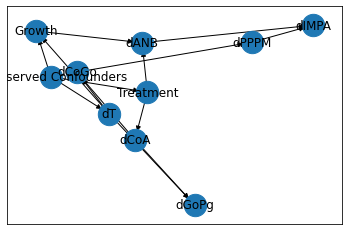

In [2]:
G = nx.DiGraph()

G.add_edges_from(
    [("Unobserved Confounders", "Treatment"), 
     ("Unobserved Confounders", "dT"),
     ("Unobserved Confounders", "Growth"),
     ("Treatment", "dANB"),
     ("Treatment", "dCoA"),
     ("Growth", "dANB"),
     ("dANB", "dIMPA"),
     ("dT", "Growth"),
     ("dT", "dGoPg"),
     ("dT", "dCoGo"),
     ("dCoA", "dCoGo"),
     ("dCoA", "dGoPg"),
     ("dCoGo", "dPPPM"),
     ("dPPPM", "dIMPA")
    ])


pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='black')
nx.draw_networkx_labels(G, pos)
plt.show()

As we can see fromt he provided graph the Treatment assignment, Growth and number of years between two measurements are likely to be affected by some unobserved confounders.

Given the graph, select the variables to condition on, apply suitable adjustment method, and calculate your estimates of causal effects: Treatment on Growth, Treatment on dANB, both ATE and ATET.

In [3]:
data = pd.read_csv("malocclusion.csv")
data.head(10)

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment
0,-3.2,-1.1,-4.2,1.0,4.0,3.7,5,0,0
1,-0.6,-0.5,3.8,2.6,-0.1,1.4,3,1,0
2,-1.6,-3.1,-6.0,4.3,4.2,7.1,5,0,0
3,-1.1,-2.1,-12.1,14.1,20.7,17.5,9,0,0
4,-1.1,0.0,-6.7,7.7,8.8,11.0,5,0,0
5,-0.6,-0.9,-1.1,0.1,-1.0,0.9,3,1,0
6,-1.2,-1.8,1.8,1.6,1.7,3.0,3,1,0
7,-0.1,-2.3,1.6,2.5,4.1,0.1,2,1,0
8,0.6,-0.9,0.6,5.1,5.1,8.7,3,0,1
9,-3.0,-2.6,0.4,11.9,14.7,16.5,11,0,0


# Treatment on Growth

The Treatment and growth have a common node Unobserved Confounders.

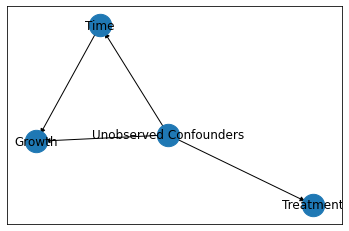

In [4]:
G = nx.DiGraph()

G.add_edges_from(
    [("Unobserved Confounders", "Treatment"),
     ("Unobserved Confounders", "Growth"),
     ("Unobserved Confounders", "Time"),
     ("Time", "Growth")])

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='black')
nx.draw_networkx_labels(G, pos)
plt.show()

# Naive ATE Estimator

In [5]:
ATE_Naive_estimate = data[data.Treatment == 1].Growth.mean() - data[data.Treatment == 0].Growth.mean()
ATE_Naive_estimate

0.1471861471861472

### Regression

In [6]:
reg_model_1 = smf.ols('Growth ~ dT + Treatment', data=data).fit()
print(reg_model_1.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4623      0.086      5.382      0.000       0.292       0.632
dT            -0.0325      0.017     -1.894      0.060      -0.066       0.001
Treatment      0.2088      0.088      2.385      0.018       0.036       0.382


ATE estimate is 0.2088

### Propensity score weighting

In [7]:
cls = LogisticRegression()
cls = CalibratedClassifierCV(cls)
                             

X = data[['dT']]
y = data['Treatment']
cls.fit(X, y)
data['e'] = cls.predict_proba(X)[:,1].tolist()


data['w'] = data['Treatment'] / data['e'] + (1 - data['Treatment']) / (1 - data['e'])
m = smf.wls('Growth ~ dT + Treatment', data=data, weights=data['w'])
fitted = m.fit()
print(fitted.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4515      0.092      4.930      0.000       0.270       0.633
dT            -0.0299      0.014     -2.161      0.032      -0.057      -0.003
Treatment      0.2083      0.079      2.623      0.010       0.051       0.365


Propensity Score Weighting ATE estimate is 0.2083

# Doubly robust estimator

In [8]:
y0 = LinearRegression().fit(data[data.Treatment == 0][['dT']], data[data.Treatment == 0]['Growth']).predict(data[['dT']])
y1 = LinearRegression().fit(data[data.Treatment == 1][['dT']], data[data.Treatment == 1]['Growth']).predict(data[['dT']])

data['DR0'] = (1-data['Treatment']) * (data['Growth'] - y0)/(1-data['e']) + y0
data['DR1'] =    data['Treatment']  * (data['Growth'] - y1)/   data['e']  + y1


In [9]:
ATE_DR = data['DR1'].mean() - data['DR0'].mean()
print("The Doubly Robust ATE: ", ATE_DR)

The Doubly Robust ATE:  0.19901991595095342


### Matching with Mahalanobis distance

In [23]:
adjustment_set = ['dT']

causal = CausalModel(
    Y=data['Growth'].values, # outcome
    D=data['Treatment'].values, # treatment
    X=data[adjustment_set].values
)

causal.est_via_matching(bias_adj=True)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.320      0.120      2.678      0.007      0.086      0.554
           ATC      0.338      0.155      2.179      0.029      0.034      0.641
           ATT      0.300      0.130      2.307      0.021      0.045      0.554



The ATE in this case is 0.32

### Propensity Score Matching

In [11]:
causal = CausalModel(
    Y=data['Growth'].values, 
    D=data['Treatment'].values,
    X=data['e'].values
)
causal.est_via_matching(bias_adj=True)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.320      0.119      2.678      0.007      0.086      0.554
           ATC      0.337      0.155      2.174      0.030      0.033      0.640
           ATT      0.300      0.130      2.314      0.021      0.046      0.553



The ATE after the Propensity Score Matching is 0.32

### Results
* The Naive ATE is 0.1471
* The Regression ATE is 0.2088
* The Propensity score weighting ATE is 0.2083
* The Doubly Robust ATE is  0.1990
* The Matching with Mahalanobis distance is 0.32
* The Propensity Score Matching ATE is 0.32

# Treatment on dANB

Treatment and Growth collides on to dANB, but in order to find the causal association (causation) of Treatment on dANB, we have to block all backdoor paths from Treatment to dANB

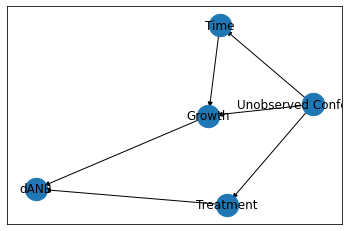

In [12]:
G = nx.DiGraph()

G.add_edges_from([
    ("Unobserved Confounders", "Treatment"),
    ("Unobserved Confounders", "Time"),
    ("Unobserved Confounders", "Growth"),
    ("Time", "Growth"),
    ("Growth", "dANB"),
    ("Treatment", "dANB"),
    ("Growth", "Growth")
])

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='black')
nx.draw_networkx_labels(G, pos)
plt.show()

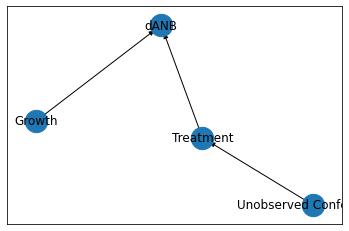

In [13]:
G = nx.DiGraph()

G.add_edges_from([
    ("Unobserved Confounders", "Treatment"),
    ("Growth", "dANB"),
    ("Treatment", "dANB"),
    ("Growth", "Growth")
])

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='black')
nx.draw_networkx_labels(G, pos)
plt.show()

#### Naive ATE

In [14]:
reg_model_1 = smf.ols("dANB ~ Treatment", data=data).fit()
print(reg_model_1.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1636      0.174     -6.702      0.000      -1.507      -0.820
Treatment      2.0288      0.256      7.938      0.000       1.524       2.534


## Regression 

In [15]:
model_2 = smf.ols("dANB ~ Growth + Treatment", data=data).fit().summary().tables[1]
print(model_2)

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5600      0.181     -8.609      0.000      -1.918      -1.202
Growth         1.1740      0.244      4.812      0.000       0.692       1.656
Treatment      1.8560      0.240      7.724      0.000       1.381       2.331


### Propensity Score Weighting

In [16]:
cls = LogisticRegression()
cls = CalibratedClassifierCV(cls)
                             

X = data[['Growth']]
y = data['Treatment']
cls.fit(X, y)
data['e'] = cls.predict_proba(X)[:,1].tolist()
data.head()

data['w'] = data['Treatment'] / data['e'] + (1 - data['Treatment']) / (1 - data['e'])
m = smf.wls('dANB ~ Growth + Treatment', data=data, weights=data['w'])
fitted = m.fit()
print(fitted.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5572      0.205     -7.609      0.000      -1.962      -1.153
Growth         1.1681      0.242      4.834      0.000       0.690       1.646
Treatment      1.8570      0.241      7.701      0.000       1.380       2.334


###  Doubly robust estimator

In [17]:
y0 = LinearRegression().fit(data[data.Treatment == 0][['Growth']], data[data.Treatment == 0]['dANB']).predict(data[['Growth']])
y1 = LinearRegression().fit(data[data.Treatment == 1][['Growth']], data[data.Treatment == 1]['dANB']).predict(data[['Growth']])

data['DR0_1'] = (1-data['Treatment']) * (data['dANB'] - y0)/(1-data['e']) + y0
data['DR1_1'] =    data['Treatment']  * (data['dANB'] - y1)/   data['e']  + y1


In [18]:
ATE_DR = data['DR1_1'].mean() - data['DR0_1'].mean()
print("The Doubly Robust ATE: ", ATE_DR)

The Doubly Robust ATE:  1.8563721534875373


### Matching with Mahalanobis distance

In [21]:
adjustment_set = ['Growth']

causal = CausalModel(
    Y=data['dANB'].values,
    D=data['Treatment'].values, 
    X=data[adjustment_set].values
)

causal.est_via_matching(bias_adj=True)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.856      0.237      7.829      0.000      1.392      2.321
           ATC      1.860      0.240      7.761      0.000      1.390      2.330
           ATT      1.852      0.240      7.723      0.000      1.382      2.322



### Propensity Score Matching

In [20]:
causal = CausalModel(
    Y=data['dANB'].values, 
    D=data['Treatment'].values,
    X=data['e'].values
)
causal.est_via_matching(matches = 1, bias_adj=True)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.856      0.237      7.829      0.000      1.392      2.321
           ATC      1.860      0.240      7.761      0.000      1.390      2.330
           ATT      1.852      0.240      7.723      0.000      1.382      2.322



### Results
* The Naive ATE is 0.2028
* The Regression ATE is 0.1856
* The Propensity score weighting ATE is 0.1857
* The Doubly Robust ATE is  0.1856
* The Matching with Mahalanobis distance is 1.856
* The Propensity Score Matching ATE is 1.856